In [33]:

import socket, sys
socket.gethostname(), sys.executable
### init1 degil de bunu baz almaliyim btw
### readme'deki conflicti duzelt.
### wrap around mantigini bi duzelt. ama once mantigini anlaman lazim tabi. kendin karar ver nasil caliscagina.

('login1', '/project/def-nahee/kbas/pone_offline/graphnet_env/bin/python')

#  0 ) Imports & Notes & configuration

In [34]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
azimuth_test_predictions_path =  Path("azimuth") / "test_predictions.csv"
azimuth_metrics_path =  Path("azimuth") / "metrics.csv"
df_azimuth_test_predictions = pd.read_csv(azimuth_test_predictions_path)
df_azimuth_metrics = pd.read_csv(azimuth_metrics_path)



# 1) test_predictions.csv

Flow:
- 1.1) Confirm columns / NaNs / Infs.
- 1.2) Look at the global residual histogram.
- 1.3) Check residual vs true angle (trend + spread).
- 1.4) Quantify resolution with **W** (both equal-width and equal-population bins).
- 1.5) Assess bias with median residual and pred/true ratio.   ## bunu acaba radian ile mi yapsam


## a)  Confirm columns / NaNs / Infs.

In [36]:
print("shape:", df_azimuth_test_predictions.shape)
print("columns:", list(df_azimuth_test_predictions.columns))

shape: (41311, 11)
columns: ['true_azimuth_radian', 'pred_azimuth_radian', 'true_azimuth_degree', 'pred_azimuth_degree', 'true_azimuth_degree_signed', 'pred_azimuth_degree_signed', 'pred_azimuth_degree_adj', 'kappa', 'event_id', 'residual_azimuth_radian', 'residual_azimuth_degree']


In [37]:
numeric_cols = df_azimuth_test_predictions.select_dtypes(include=[np.number]).columns
minmax = df_azimuth_test_predictions[numeric_cols].agg(["min", "max"]).T

print(minmax)

                                   min            max
true_azimuth_radian           0.000005       6.282984
pred_azimuth_radian           0.000002       6.283117
true_azimuth_degree           0.000282     359.988495
pred_azimuth_degree           0.000141     359.996094
true_azimuth_degree_signed -179.997925     179.988617
pred_azimuth_degree_signed -179.997192     179.982819
pred_azimuth_degree_adj    -162.502304     532.865295
kappa                         0.013280     165.127792
event_id                     18.000000  402910.000000
residual_azimuth_radian      -3.141270       3.137959
residual_azimuth_degree    -179.981537     179.791794


##### Column ranges (min / max)

The table above reports the **minimum** and **maximum** value observed in each **numeric** column of `df_azimuth_test_predictions`.

**Units**
- `true_azimuth` and `pred_azimuth` are in **radians** (expected physical range: \[0, 2π\]).
- `abs_error_deg` is in **degrees**.
- `kappa` is **dimensionless** (concentration parameter).
- `event_id` is an **integer identifier** (unitless).

In [38]:
print("Rows:", len(df_azimuth_test_predictions))

print("\nNaN counts (all columns):")
print(df_azimuth_test_predictions.isna().sum())

Rows: 41311

NaN counts (all columns):
true_azimuth_radian           0
pred_azimuth_radian           0
true_azimuth_degree           0
pred_azimuth_degree           0
true_azimuth_degree_signed    0
pred_azimuth_degree_signed    0
pred_azimuth_degree_adj       0
kappa                         0
event_id                      0
residual_azimuth_radian       0
residual_azimuth_degree       0
dtype: int64


In [39]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_azimuth_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)

Inf counts (numeric columns):
                            +inf  -inf  any_inf
true_azimuth_radian            0     0        0
pred_azimuth_radian            0     0        0
true_azimuth_degree            0     0        0
pred_azimuth_degree            0     0        0
true_azimuth_degree_signed     0     0        0
pred_azimuth_degree_signed     0     0        0
pred_azimuth_degree_adj        0     0        0
kappa                          0     0        0
event_id                       0     0        0
residual_azimuth_radian        0     0        0
residual_azimuth_degree        0     0        0


In [40]:
# ---- global W over the full test set ----
r = df_azimuth_test_predictions["residual_azimuth_degree"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")

p16=-5.9289, p50=-0.1462, p84=5.6586, W=5.7937


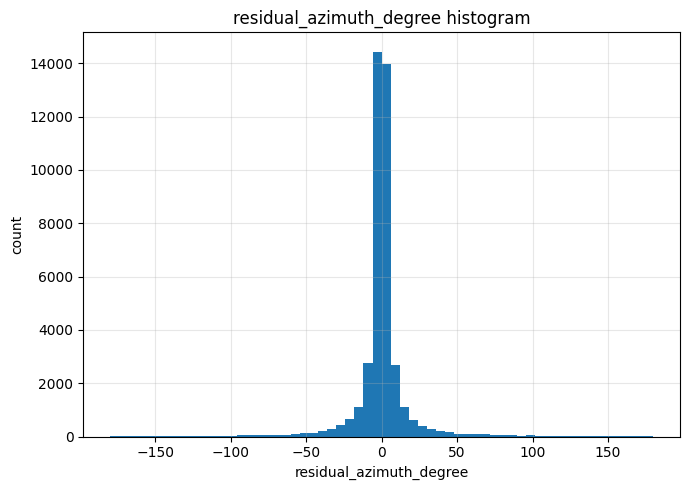

In [41]:

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("residual_azimuth_degree")
plt.ylabel("count")
plt.title("residual_azimuth_degree histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

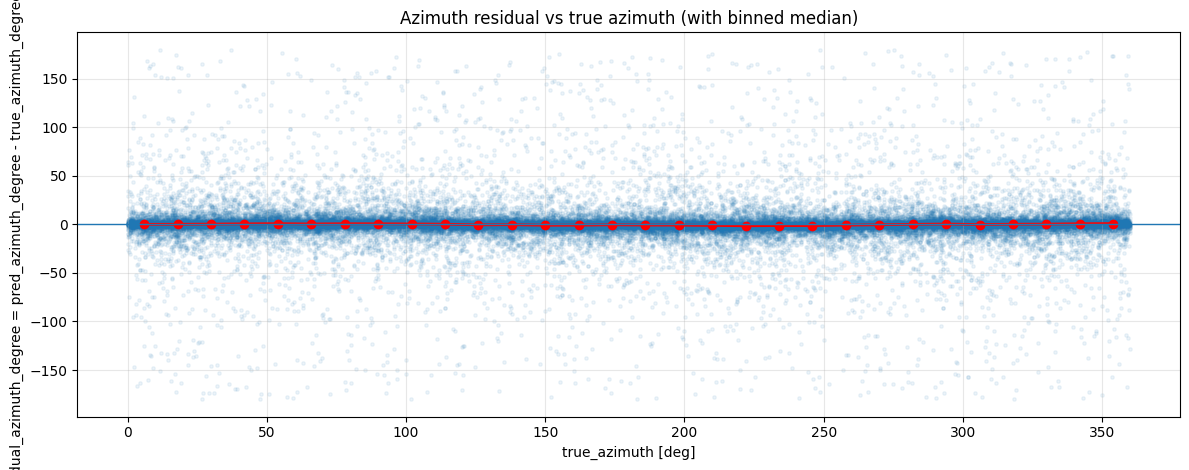

In [42]:
# ---- Azimuth: residual vs true_azimuth scatter + binned median (NO subsample) ----

x = df_azimuth_test_predictions["true_azimuth_degree"].to_numpy(dtype=float)


plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("true_azimuth [deg]")
plt.ylabel("residual_azimuth_degree = pred_azimuth_degree - true_azimuth_degree [deg]")
plt.title("Azimuth residual vs true azimuth (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

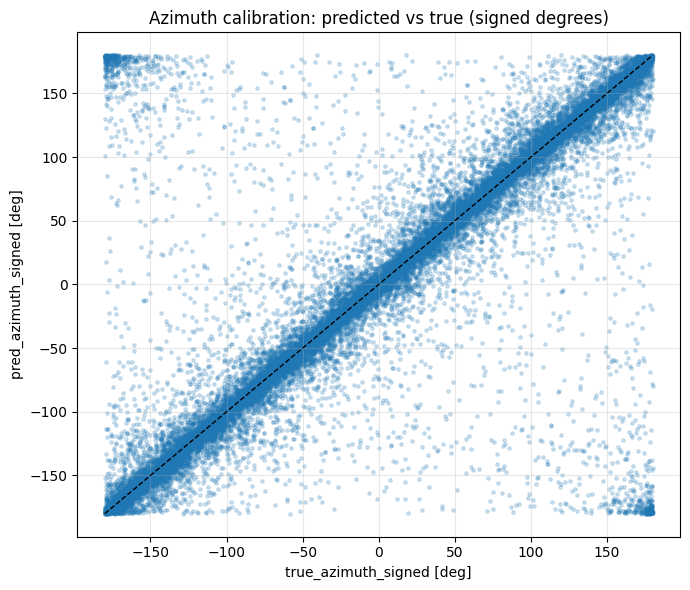

In [43]:
# ---- Azimuth: calibration scatter (SIGNED degree space) ----
plt.figure(figsize=(7, 6))

plt.scatter(
    df_azimuth_test_predictions["true_azimuth_degree_signed"],
    df_azimuth_test_predictions["pred_azimuth_degree_signed"],
    s=6, alpha=0.2
)

xmin = df_azimuth_test_predictions["true_azimuth_degree_signed"].min()
xmax = df_azimuth_test_predictions["true_azimuth_degree_signed"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)

plt.xlabel("true_azimuth_signed [deg]")
plt.ylabel("pred_azimuth_signed [deg]")
plt.title("Azimuth calibration: predicted vs true (signed degrees)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


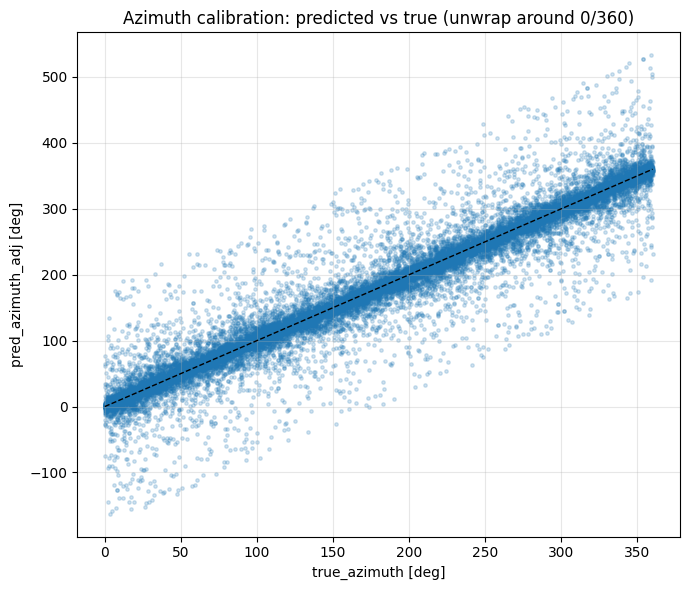

In [44]:
# ---- Azimuth: calibration scatter (UNWRAPPED pred_adj vs true) ----
plt.figure(figsize=(7, 6))

plt.scatter(
    df_azimuth_test_predictions["true_azimuth_degree"],
    df_azimuth_test_predictions["pred_azimuth_degree_adj"],
    s=6, alpha=0.2
)

xmin = df_azimuth_test_predictions["true_azimuth_degree"].min()
xmax = df_azimuth_test_predictions["true_azimuth_degree"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)

plt.xlabel("true_azimuth [deg]")
plt.ylabel("pred_azimuth_adj [deg]")
plt.title("Azimuth calibration: predicted vs true (unwrap around 0/360)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


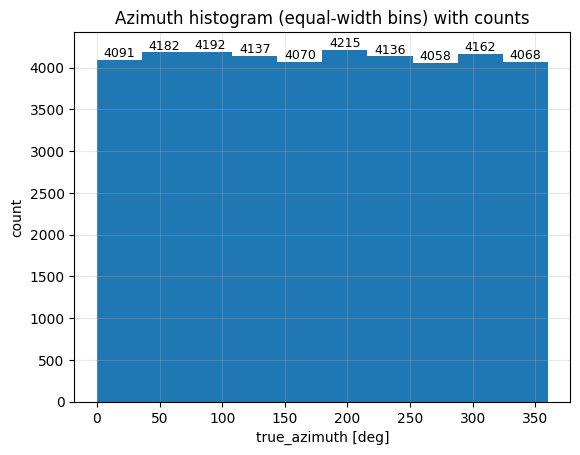

In [45]:
# ---- Azimuth: histogram with counts annotated on top of bars ----
n_bins_azimuth = 10
bins_azimuth = np.linspace(
    df_azimuth_test_predictions["true_azimuth_degree"].min(),
    df_azimuth_test_predictions["true_azimuth_degree"].max(),
    n_bins_azimuth + 1,
)
values = df_azimuth_test_predictions["true_azimuth_degree"].to_numpy(dtype=float)

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_azimuth)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("true_azimuth [deg]")
plt.ylabel("count")
plt.title("Azimuth histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()


# bu neden duzgun dagilmiyo? tm bu normalmis

In [46]:
# ---- Azimuth: W table per azimuth bin (using residual_azimuth in radians) ----

df_azimuth_w_rows = []



# Use histogram edges from your azimuth hist cell:
# counts, edges, patches = plt.hist(...)
# If your variable name is edges_azimuth, replace edges -> edges_azimuth below.
for left, right in zip(edges[:-1], edges[1:]):
    # match matplotlib hist logic: [left, right) except last bin includes right
    if right == edges[-1]:
        mask = (df_azimuth_test_predictions["true_azimuth_degree"] >= left) & (df_azimuth_test_predictions["true_azimuth_degree"] <= right)
    else:
        mask = (df_azimuth_test_predictions["true_azimuth_degree"] >= left) & (df_azimuth_test_predictions["true_azimuth_degree"] < right)

    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_azimuth_w_rows.append({
        "Abin": f"({left:.3f}, {right:.3f}]",
        "A_center_deg": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_azimuth_W_table = pd.DataFrame(df_azimuth_w_rows)
df_azimuth_W_table

,Abin,A_center_deg,count,p16,p50,p84,W
0,"(0.000, 35.999]",17.999693,41311,-5.928878,-0.146193,5.658621,5.793749
1,"(35.999, 71.998]",53.998514,41311,-5.928878,-0.146193,5.658621,5.793749
2,"(71.998, 107.997]",89.997335,41311,-5.928878,-0.146193,5.658621,5.793749
3,"(107.997, 143.996]",125.996156,41311,-5.928878,-0.146193,5.658621,5.793749
4,"(143.996, 179.994]",161.994978,41311,-5.928878,-0.146193,5.658621,5.793749
5,"(179.994, 215.993]",197.993799,41311,-5.928878,-0.146193,5.658621,5.793749
6,"(215.993, 251.992]",233.992620,41311,-5.928878,-0.146193,5.658621,5.793749
7,"(251.992, 287.991]",269.991442,41311,-5.928878,-0.146193,5.658621,5.793749
8,"(287.991, 323.990]",305.990263,41311,-5.928878,-0.146193,5.658621,5.793749
9,"(323.990, 359.988]",341.989084,41311,-5.928878,-0.146193,5.658621,5.793749


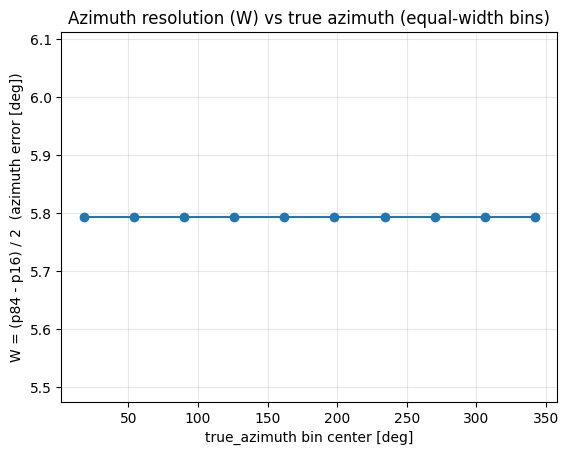

In [47]:
# ---- Azimuth: plot W vs true azimuth (equal-width bins) ----

plt.figure()
plt.plot(df_azimuth_W_table["A_center_deg"], df_azimuth_W_table["W"], marker="o")
plt.xlabel("true_azimuth bin center [deg]")
plt.ylabel("W = (p84 - p16) / 2  (azimuth error [deg])")
plt.title("Azimuth resolution (W) vs true azimuth (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()

In [48]:
# ---- create equal-population bins (qcut) ----

n_qbins_azimuth = 10

df_azimuth_test_predictions["Abin_q"] = pd.qcut(
    df_azimuth_test_predictions["true_azimuth_degree"],
    q=n_qbins_azimuth,
    duplicates="drop",
)

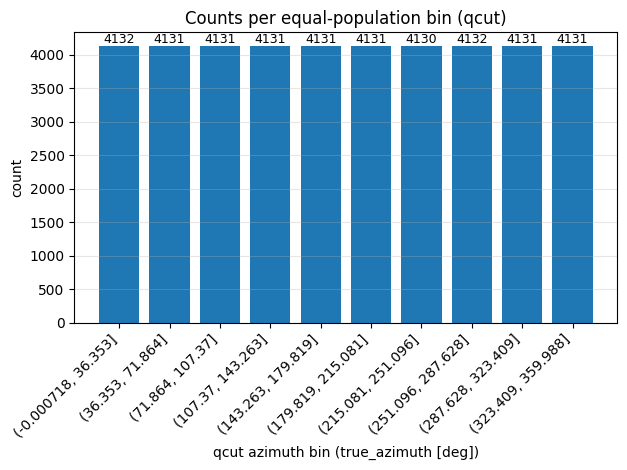

In [49]:
# ---- plot counts per qcut bin ----

bin_counts_q = df_azimuth_test_predictions["Abin_q"].value_counts().sort_index()

plt.figure()
plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(
    range(len(bin_counts_q)),
    [str(i) for i in bin_counts_q.index],
    rotation=45,
    ha="right",
)
plt.xlabel("qcut azimuth bin (true_azimuth [deg])")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

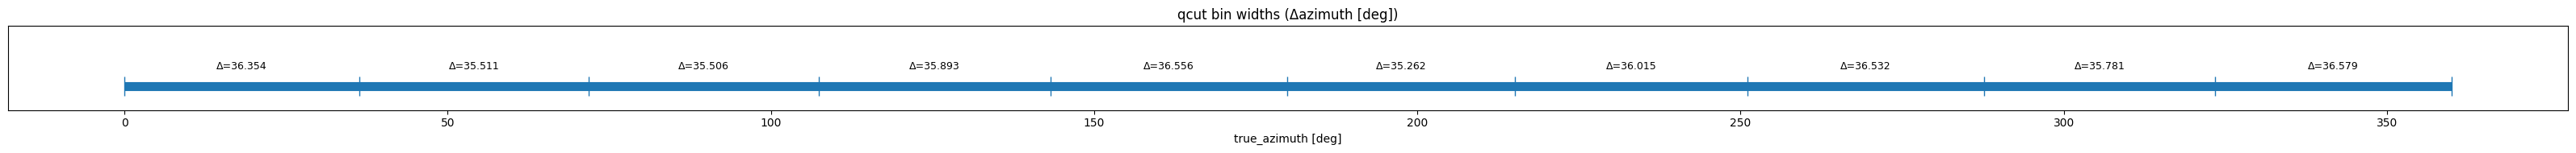

In [50]:
# ---- Visualize qcut bin widths only (in azimuth radian space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("true_azimuth [deg]")
plt.title("qcut bin widths (Δazimuth [deg])")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()

In [51]:
# ---- Azimuth: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_azimuth_q = []
for iv, g in df_azimuth_test_predictions.groupby("Abin_q", observed=True):
    r = (g["pred_azimuth_degree"] - g["true_azimuth_degree"]).to_numpy(dtype=float)  # residual in radians

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_azimuth_q.append({
        "Abin_q": str(iv),
        "A_center_deg": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_azimuth_W_table_q = pd.DataFrame(rows_azimuth_q).sort_values("A_center_deg")
df_azimuth_W_table_q

,Abin_q,A_center_deg,count,p16,p50,p84,W
0,"(-0.000718, 36.353]",18.176141,4132,-2.428824,1.041827,23.549952,12.989388
1,"(36.353, 71.864]",54.108500,4131,-3.898129,0.714989,8.267589,6.082859
2,"(71.864, 107.37]",89.617000,4131,-3.748721,0.616684,7.510747,5.629734
3,"(107.37, 143.263]",125.316500,4131,-5.458316,-0.159241,5.722166,5.590241
4,"(143.263, 179.819]",161.541000,4131,-6.232529,-0.712067,4.448239,5.340384
5,"(179.819, 215.081]",197.450000,4131,-6.973593,-0.809586,4.442572,5.708083
6,"(215.081, 251.096]",233.088500,4130,-7.128029,-1.365479,4.810195,5.969112
7,"(251.096, 287.628]",269.362000,4132,-7.237234,-0.488098,4.288234,5.762734
8,"(287.628, 323.409]",305.518500,4131,-7.597137,-0.048737,4.720819,6.158978
9,"(323.409, 359.988]",341.698500,4131,-22.321326,-0.364258,3.295551,12.808438


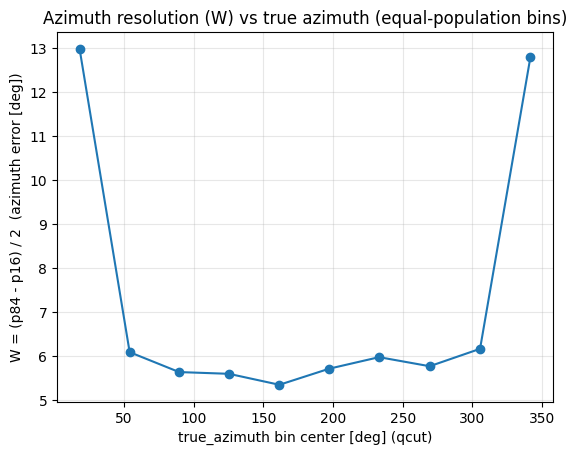

In [52]:
# ---- Azimuth: plot W vs true azimuth (qcut bins) ----

plt.figure()
plt.plot(df_azimuth_W_table_q["A_center_deg"], df_azimuth_W_table_q["W"], marker="o")
plt.xlabel("true_azimuth bin center [deg] (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (azimuth error [deg])")
plt.title("Azimuth resolution (W) vs true azimuth (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()

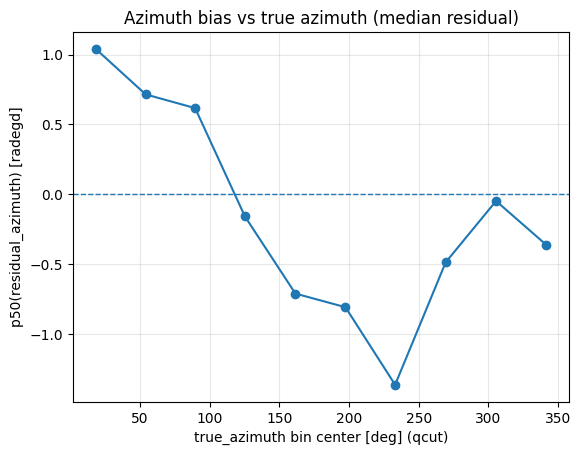

In [53]:
# ---- Azimuth: bias vs true azimuth (median residual, qcut bins) ----

plt.figure()
plt.plot(df_azimuth_W_table_q["A_center_deg"], df_azimuth_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("true_azimuth bin center [deg] (qcut)")
plt.ylabel("p50(residual_azimuth) [radegd]")
plt.title("Azimuth bias vs true azimuth (median residual)")
plt.grid(True, alpha=0.3)
plt.show()

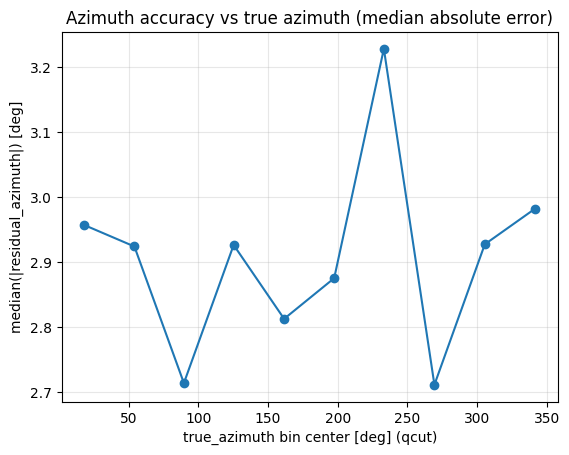

In [54]:
# ---- Azimuth: median absolute error vs true azimuth (qcut bins) ----

df_azimuth_W_table_q["abs_p50_deg"] = np.nan  # keep style similar to your energy table edits

abs_rows = []
for iv, g in df_azimuth_test_predictions.groupby("Abin_q", observed=True):
    r = (g["pred_azimuth_degree"] - g["true_azimuth_degree"]).to_numpy(dtype=float)
    abs_rows.append((str(iv), np.median(np.abs(r))))

abs_map = dict(abs_rows)
df_azimuth_W_table_q["abs_p50_deg"] = df_azimuth_W_table_q["Abin_q"].map(abs_map)

plt.figure()
plt.plot(df_azimuth_W_table_q["A_center_deg"], df_azimuth_W_table_q["abs_p50_deg"], marker="o")
plt.xlabel("true_azimuth bin center [deg] (qcut)")
plt.ylabel("median(|residual_azimuth|) [deg]")
plt.title("Azimuth accuracy vs true azimuth (median absolute error)")
plt.grid(True, alpha=0.3)
plt.show()

# 2) metrics.csv

In [55]:
print("shape:", df_azimuth_metrics.shape)
print("columns:", list(df_azimuth_metrics.columns))

shape: (27, 13)
columns: ['epoch', 'train_loss', 'val_loss', 'lr', 'best_model_is_updated', 'val_residual_p16_deg', 'val_residual_p50_deg', 'val_residual_p84_deg', 'val_W_deg', 'val_kappa_p16', 'val_kappa_p50', 'val_kappa_p84', 'val_kappa_W']


In [56]:
df_azimuth_metrics.head(5)

,epoch,train_loss,val_loss,lr,best_model_is_updated,val_residual_p16_deg,val_residual_p50_deg,val_residual_p84_deg,val_W_deg,val_kappa_p16,val_kappa_p50,val_kappa_p84,val_kappa_W
0,0,NaN,0.085779,0.000983,True,-11.433356,0.777139,12.043907,11.738632,4.052917,18.891928,48.633694,22.290388
1,1,0.764658,-0.236279,0.000950,True,-8.151605,0.621370,9.823856,8.987730,4.918227,32.615459,81.969444,38.525608
2,2,-0.162389,-0.309017,0.000916,True,-7.897096,0.623992,9.330848,8.613972,4.663252,41.684303,86.622620,40.979683
3,3,-0.293951,-0.357178,0.000883,True,-8.451591,-0.287305,7.891946,8.171768,5.500217,53.160690,97.342072,45.920929
4,4,-0.347391,-0.381400,0.000849,True,-8.160834,-0.049970,8.162884,8.161860,5.580246,54.331291,91.680344,43.050049


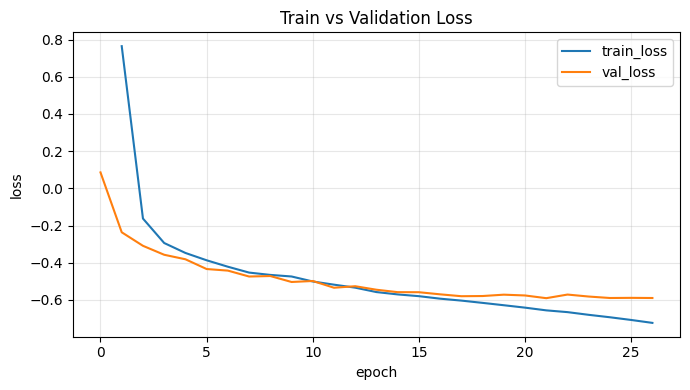

In [57]:
plt.figure(figsize=(7,4))
plt.plot(df_azimuth_metrics["epoch"], df_azimuth_metrics["train_loss"], label="train_loss")
plt.plot(df_azimuth_metrics["epoch"], df_azimuth_metrics["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()